### Implementa una red completamente conectada para la tarea de clasificacion de imagenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguientes especificaciones

* Explora con diferentes numero de neuronas, capas, funciones de activacion e hiperparametros
* Discutir los resultados con las distintas configuraciones

In [1]:
#Importamos librerias utiles
#deep learning
import torch
import torch.nn as nn
import torch.functional as func
import torch.optim as optimizer
import torchvision.datasets.utils as tutils
import torchvision.datasets as DataSets
#matrices y matematicas
import numpy as np
# tomar n elementos de una secuencia
from itertools import islice as take
#imagenes
from matplotlib import pyplot as plt

In [2]:
#cargamos el dataset de fashion-MNIST de train
fmnist_train = DataSets.FashionMNIST(root='\FashionMNIST',train=True, download=True, transform = np.array)
##cargamos el dataset de fashion-MNIST de test
fmnist_test = DataSets.FashionMNIST(root='\FashionMNIST',train=False, download=True, transform = np.array)

In [3]:
#para verificar imprimimos la info de ambos datasets
print(fmnist_train)
print('#'*50)
print(fmnist_test)
# Sembramos semillas para reproducibilidad
np.random.seed(2020)
torch.manual_seed(2020)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: \FashionMNIST
    Split: Train
    StandardTransform
Transform: <built-in function array>
##################################################
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: \FashionMNIST
    Split: Test
    StandardTransform
Transform: <built-in function array>


In [4]:
#creamos una funcion para ver n imagenes con i columnas y j filas
def muestraImagenes(columnas,filas,fmnist):
    #crea dos listas vacias que contendran las imagenes y las etiquetas respectivamente
    images, labels = [], []
    #itera sobre el producto de las filas con las columnas es decir el total de imagenes
    for image in range(int(columnas*filas)):
        #si el argumento es train
        if fmnist == 'train':
            #toma las imagenes y etiquetas del dataset train
            im , lab = fmnist_train[image]
        #si el argumento no es train
        else:
            #toma las imagenes y etiquetas del dataset test
            im , lab = fmnist_test[image]
        #has append a la lista de imagenes con la imagen actual
        images.append(im)
        #has append a la lista de etiquetas con la etiqueta actual
        labels.append(str(lab))
        #convierte a string las etiquetas
        titles = [str(y) for y in labels]
    #define una variable dummy que sirve para iterar sobre todas las imagenes
    contador = 0
    #define el array de imagenes con tamaño de 10x10
    f, axarr = plt.subplots(filas,columnas, figsize=(10,10))
    #itera sobre las filas del array de imagenes
    for fila in range(filas):
        #itera sobre las columnas del array de imagenes
        for columna in range(columnas):
            #muestra la imagen en la posicion de la variable dummy
            axarr[fila,columna].imshow(images[contador],cmap='gray')
            #muestra sobre esa imagen un titulo que corresponde a su etiqueta
            axarr[fila,columna].set_title('Label: {0}'.format(titles[contador]))
            #quita los numeros de los ejes
            axarr[fila,columna].set_xticklabels([])
            axarr[fila,columna].set_yticklabels([])
            #suma uno a la variable dummy
            contador += 1
    #muestra el array de imagenes
    plt.show()

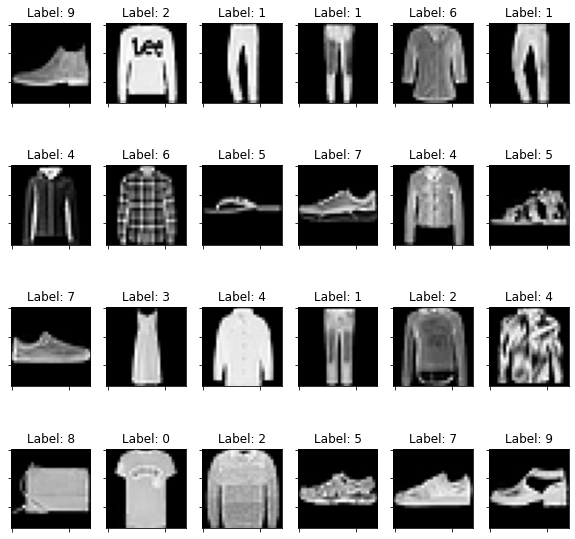

In [5]:
muestraImagenes(columnas=6,filas=4,fmnist='test')